# Necessary libraries

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
import sklearn
sklearn.__version__

'1.2.2'

In [4]:
df = pd.read_csv("/content/drive/MyDrive/CarPricePrediction/car.csv")
df.head()

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used


# Data Understanding & Cleaning

<p>There is a lot of missing values.</p>
<p>Should explore more to find a way to deal with them </p>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317636 entries, 0 to 317635
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                317636 non-null  int64  
 1   list_id           317636 non-null  int64  
 2   list_time         317636 non-null  int64  
 3   manufacture_date  317636 non-null  int64  
 4   brand             317586 non-null  object 
 5   model             317586 non-null  object 
 6   origin            234317 non-null  object 
 7   type              272934 non-null  object 
 8   seats             283792 non-null  float64
 9   gearbox           316243 non-null  object 
 10  fuel              317542 non-null  object 
 11  color             221540 non-null  object 
 12  mileage_v2        317636 non-null  int64  
 13  price             317524 non-null  float64
 14  condition         317636 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 36.4+ MB


In [6]:
df.describe(include='object')

,brand,model,origin,type,gearbox,fuel,color,condition
count,317586,317586,234317,272934,316243,317542,221540,317636
unique,67,521,10,9,4,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,65455,15719,116368,90709,239222,259244,72035,270089


In [7]:
df.describe()

,id,list_id,list_time,manufacture_date,seats,mileage_v2,price
count,3.176360e+05,3.176360e+05,3.176360e+05,317636.00000,283792.000000,317636.000000,3.175240e+05
mean,1.489581e+08,1.090510e+08,1.695835e+12,2016.53675,5.712529,61327.917528,6.265541e+08
std,3.484644e+06,2.878699e+06,1.131473e+09,26.07318,1.780515,92679.788593,7.284020e+08
min,4.588559e+07,2.989052e+07,1.691400e+12,-1.00000,-1.000000,0.000000,1.310720e+06
25%,1.490832e+08,1.091366e+08,1.695113e+12,2014.00000,5.000000,9000.000000,3.150000e+08
50%,1.499784e+08,1.099032e+08,1.695873e+12,2019.00000,5.000000,42000.000000,4.900000e+08
75%,1.504550e+08,1.103140e+08,1.696577e+12,2022.00000,7.000000,82000.000000,7.150000e+08
max,1.513698e+08,1.110970e+08,1.698210e+12,2023.00000,16.000000,999999.000000,3.750000e+10


In [8]:
df.isnull().sum()

id                      0
list_id                 0
list_time               0
manufacture_date        0
brand                  50
model                  50
origin              83319
type                44702
seats               33844
gearbox              1393
fuel                   94
color               96096
mileage_v2              0
price                 112
condition               0
dtype: int64

<p> 'model' and 'brand' have the same number of missing values and they may have a close relationship => let's start with them. </p>

### Deal with missing brand and model

In [9]:
df.groupby(['brand', 'model']).size()

brand  model    
Acura  Legend        16
       MDX           98
       RDX           44
       ZDX           42
Asia   Dòng khác     52
                   ... 
Volvo  XC40          31
       XC60         115
       XC90         139
Zotye  Dòng khác     65
       T600          19
Length: 579, dtype: int64

In [10]:
print("Missing model & Missing brand", len(np.where(df['model'].isna() & df['brand'].isna())[0]))
print("Missing model & Existing brand", len(np.where(df['model'].isna() & df['brand'].notna())[0]))
print("Existing model & Missing brand", len(np.where(df['model'].notna() & df['brand'].isna())[0]))

Missing model & Missing brand 50
Missing model & Existing brand 0
Existing model & Missing brand 0


<p> Now, it's is clear 'model' and 'brand' are missed in the same positions. </p>
<p> Since, the total number of missing values is only 50 -> It's ok to replace them with the most frequent values </p>

In [11]:
most_freq_model, most_freq_type = df.groupby(['model', 'brand']).size().idxmax()

In [12]:
df['model'] = df['model'].fillna(most_freq_model)
df['brand'] = df['brand'].fillna(most_freq_type)

<p>It can be seen that the name of models between brands are mostly different, so I combine these two columns

In [13]:
df['brand_model'] = df['brand'] + "-" + df['model']

In [14]:
df.head()

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,brand_model
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,Jeep-A2
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,Honda-City
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used,Kia-Rio
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,Toyota-Vios
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used,Fiat-Siena


### Deal with missing fuel, type, gearbox, seats, color

In [15]:
# print(df.groupby(['brand_model', 'fuel']).size().to_string())

In [16]:
# print(df.groupby(['brand_model', 'type']).size().to_string())

In [17]:
# print(df.groupby(['brand_model', 'seats']).size().to_string())

<p>Each model focuses on specific categories of fuel, type, seats, gearbox, color => the missing values can be replaced by the most frequent values of their brands</p>

In [18]:
def replace_missing_values(df, cate):
  brand_names = df[df[cate].isna()]['brand_model'].unique()
  for brand_name in brand_names:
    try:
      most_freq_value = df[df['brand_model'] == brand_name].groupby([cate]).size().idxmax()
      df.loc[df['brand_model'] == brand_name, cate] =  df.loc[df['brand_model'] == brand_name, cate].fillna(most_freq_value)
    except ValueError:
      brand_name = brand_name.split('-')[0]
      if len(df[df['brand'] == brand_name].groupby([cate]).size()) == 0:
        df.drop(index=np.where(df['brand'] == brand_name)[0], inplace=True)
      else:
        most_freq_value = df[df['brand'] == brand_name].groupby([cate]).size().idxmax()
        df.loc[df['brand'] == brand_name, cate] =  df.loc[df['brand'] == brand_name, cate].fillna(most_freq_value)
  return df

In [19]:
columns = ['fuel', 'type', 'seats', 'gearbox', 'color', 'origin']
for col in columns:
  df = replace_missing_values(df, col)

In [20]:
df.isnull().sum()

id                    0
list_id               0
list_time             0
manufacture_date      0
brand                 0
model                 0
origin                0
type                  0
seats                 0
gearbox               0
fuel                  0
color                 0
mileage_v2            0
price               112
condition             0
brand_model           0
dtype: int64

### Deal with missing prices

<p>Since 'price' is the output so I want to make sure it is as correct as possible</p>
<p>Moreover, the number of missing prices is small so I will drop all the rows with missing price</p>

In [21]:
df = df.dropna(subset=['price'])

In [22]:
df.isnull().sum()

id                  0
list_id             0
list_time           0
manufacture_date    0
brand               0
model               0
origin              0
type                0
seats               0
gearbox             0
fuel                0
color               0
mileage_v2          0
price               0
condition           0
brand_model         0
dtype: int64

In [23]:
df2 = df.drop(columns=['brand_model', 'model', 'id', 'list_id', 'list_time'])

In [24]:
df2.head()

,manufacture_date,brand,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,2016,Kia,Hàn Quốc,Sedan,5.0,AT,petrol,white,78545,295000000.0,used
3,2020,Toyota,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,2001,Fiat,Việt Nam,Sedan,5.0,MT,petrol,white,200000,73000000.0,used


# Visualization

In [25]:
def count_plot(column_name, hue = None, rotation = 0):
    """
    1) input : column name, column data type must be object or categorical
    3) output : cout plot using seaborn modules, unique values in x-axis and frequency in y-axis
    4) i use bar_label to show frequency of each unique values above each column in graph
    """
    graph = sns.countplot(x = column_name, data = df2, hue = hue)
    for container in graph.containers:
        graph.bar_label(container)

    plt.xticks(rotation = rotation)
    plt.show()

def box_plot(x, y):
  sns.boxplot(data=df2, x = x, y = y)
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

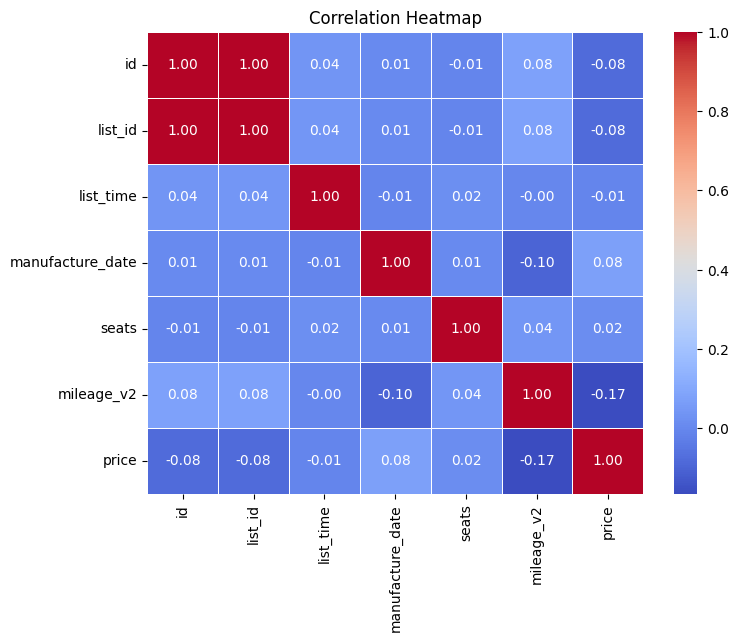

In [26]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

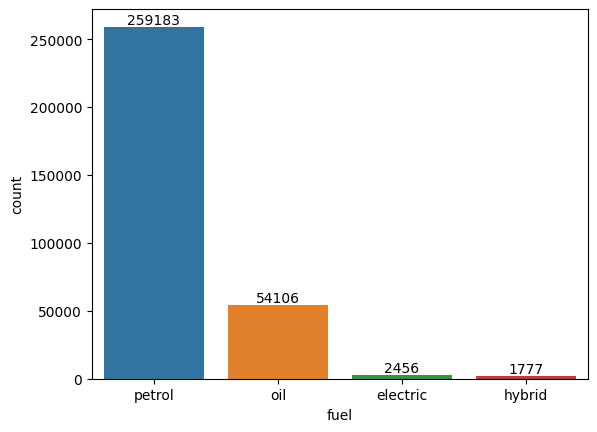

In [27]:
count_plot('fuel')

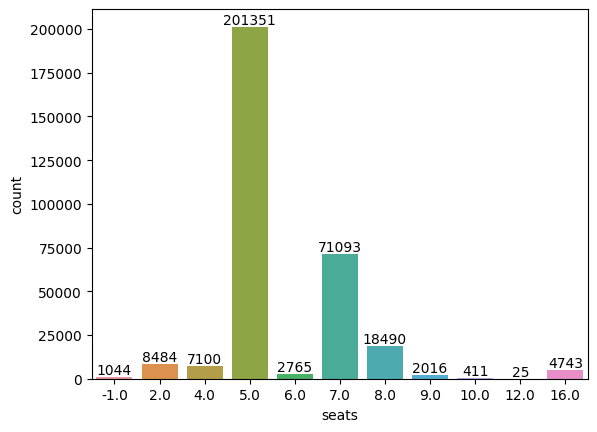

In [28]:
count_plot('seats')

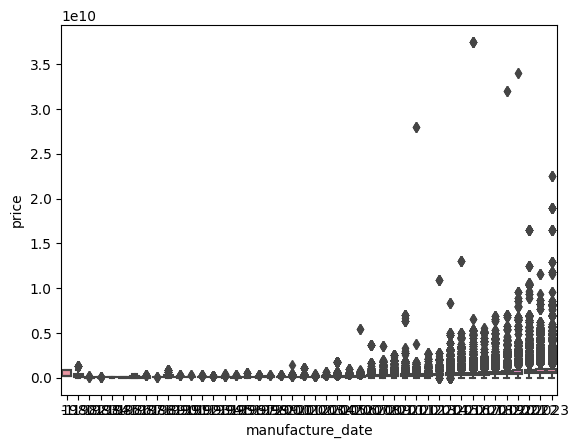

In [29]:
box_plot(x='manufacture_date', y='price')

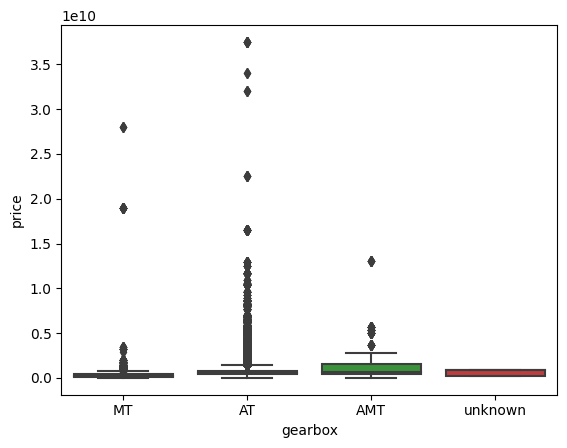

In [30]:
box_plot(x='gearbox', y='price')

# Preprocessing

In [31]:
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

In [32]:
categorical_variables = ['brand', 'origin', 'type', 'gearbox', 'fuel', 'color', 'condition']
numerical_variables = ['mileage_v2', 'manufacture_date', 'seats']

In [33]:
for cat in categorical_variables:
  df2[cat] = label_encoder.fit_transform(df2[cat])

In [34]:
df2.head()

,manufacture_date,brand,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,30,1,6,4.0,2,3,4,40000,380000000.0,1
1,2021,24,2,7,5.0,1,3,11,23000,455000000.0,1
2,2016,31,0,7,5.0,1,3,11,78545,295000000.0,1
3,2020,61,6,7,5.0,2,3,11,99999,368000000.0,1
4,2001,18,6,7,5.0,2,3,11,200000,73000000.0,1


In [35]:
df2.to_csv('processed_data.csv', index=None)

In [36]:
X = df2.drop(columns=['price'])
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train[numerical_variables] = scaler.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])

# Model

In [37]:
reg = xgb.XGBRegressor(n_estimators=1000, )
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
y_hat = reg.predict(X_test)

In [39]:
r2 = r2_score(y_test, y_hat)

In [48]:
r2

0.9705495132639628